In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import spacy
import re
import string
import pandas as pd
import nltk
import email
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.image as mpimg
from tensorflow.keras.layers import Input, Concatenate, Attention, Reshape, Layer, Lambda, MultiHeadAttention
from keras import backend as K
import random
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
from tensorflow.keras.metrics import Accuracy, Precision, Recall, MeanSquaredError, AUC
from nltk.corpus import stopwords
import shutil
import tensorflow_hub as hub
import tensorflow_text as text
from PIL import Image
import pytesseract

In [6]:
# Liste des textes à remplacer
liste_textes_ham_a_remplacer = [
    "Thanks for your interest in Abnormal Security. We've received your application. We understand job searching takes significant time and energy, and pride ourselves on an excellent candidate experience. Because of that, we try hard to set clear expectations about whats to come. You can count on hearing from us if theres a clear alignment between your skills/experience and our business needs, and we're at the point in the hiring process where we're still reviewing applications.Were experiencing tremendous growth and are receiving a high number of inbound applications.While we're confident that our tools and processes allow us to discover the very best candidates from among that pool of applicants, it's not possible to follow up personally with all applicants.Thanks again for your time and interest Regards",
    "Hello,Weve received a request to reset the password for the account associated with mahditari91@gmail.com. No changes have been made to your account yet.You can reset your password by clicking the link below:Reset your passwordIf you did not request a new password, please ignore this email.",
    "Bonjour, Merci de magasiner avec nous. Nous avons pensé que vous aimeriez savoir que votre article a été expédié. Votre commande est ainsi complète. Votre commande est en route et n'est plus modifiable. Si vous devez retourner un article dans cet envoi ou gérer d'autres commandes, veuillez visiter Vos commandes sur Amazon.ca.Confirmation de l'envoiVotre date de livraison garantie est : vendredi 17 maiEnvoyez à Mr, QuebecGatineauCommande # 701-8036979-4166660Suivez votre colisTotal de la commandeCDN$ 49.43Votre colis est expédié par INTELCOM et le numéro de suivi est INTLCME770223791. Selon le mode de livraison que vous avez choisi, il peut s'écouler jusqu'à 24 heures avant que votre numéro de suivi ne renvoie des informations.Les retours sont faciles. Visitez notre Service de retours en ligneApprenez comment recycler vos emballages avec Amazon Second Chance.Si vous avez besoin d'aide avec votre commande, veuillez visiter le Service à la clientèle.Nous espérons vous revoir bientôt! ",
    "Bonjour, Nous avons bien reçu votre demande de rendez-vous. Nous vous contacterons sous peu pour convenir d'une date et d'une heure qui vous conviennent. Cordialement,",
    "Objet : Confirmation de réservation Bonjour, Nous vous confirmons votre réservation pour le concert de jazz le 25 juin à l'Hôtel de Ville. Nous avons hâte de vous accueillir parmi nous. Cordialement, L'équipe de JazzMania",
    "Bonjour, Nous vous informons que votre abonnement à notre service a été renouvelé avec succès. Vous pouvez continuer à profiter de tous nos avantages. Cordialement",
    "Bonjour, Le nettoyage du stationnement est complété. Vous pouvez retourner à votre espace attitré à partir de maintenant si vous le voulez. Les portes du stationnement P2 (rue Montcalm) resteront ouvertes jusqu'à 16:30.Merci pour votre habituelle collaboration.Cordialement",
    "Hi, Thank you for expressing your interest in joining the global team at Sardine. We're delighted to have captured your attention and have received your application for the Machine Learning Engineer role.Our team will review your application and be in touch if you're the right fit. Thank you again for your interest in Sardine, and have a great day!Best Regards",
    "Votre colis INTLCME605467576 a été livrée sans signature aujourd'hui à 12:59PM. Faites défiler vers le bas pour afficher votre preuve de livraison.Comment évaluez-vous votre expérience de livraison?Cliquez sur l’étoile!1 star rating   2 star rating   3 star rating   4 star rating   5 star ratingVous avez des questions à propos de votre livraison? Voici des réponses.Bonne journée!"
]

liste_textes_spam_a_remplacer = ["Thanks for your interest in Abnormal Security. We've received your application. We understand job searching takes significant time and energy, and pride ourselves on an excellent candidate experience. Because of that, we try hard to set clear expectations about whats to come. You can count on hearing from us if theres a clear alignment between your skills/experience and our business needs, and we're at the point in the hiring process where we're still reviewing applications.Were experiencing tremendous growth and are receiving a high number of inbound applications.While we're confident that our tools and processes allow us to discover the very best candidates from among that pool of applicants, it's not possible to follow up personally with all applicants.Thanks again for your time and interest Regards", 
                            "Microsoft Teams Besoin d'aide ?<https://aka.ms/JoinTeamsMeeting?omkt=fr-FR>Rejoindre la réunion maintenant<https://teams.microsoft.com/l/meetup-join/19%3ameeting_MDc2MjBjNWMtYjg5MS00MzJjLTkxMjUtZmVjZTVjYzM5MWI2%40thread.v2/0?context=%7b%22Tid%22%3a%226687f505-9f93-4b52-8449-0f78ad76d9a4%22%2c%22Oid%22%3a%22ca90ba51-9c80-4788-95c4-209634aa4fa5%22%7d>ID de réunion : 236 025 094 761Code secret : tzubJuPour les organisateurs : Options de réunion<https://teams.microsoft.com/meetingOptions/?organizerId=ca90ba51-9c80-4788-95c4-209634aa4fa5&tenantId=6687f505-9f93-4b52-8449-0f78ad76d9a4&threadId=19_meeting_MDc2MjBjNWMtYjg5MS00MzJjLTkxMjUtZmVjZTVjYzM5MWI2@thread.v2&messageId=0&language=fr-FR> ", 
                            "Travailler de chez vous et gagner 5000€ par mois ! Rejoignez notre programme de travail à domicile et gagnez jusqu'à 5000€ par mois. Aucune expérience nécessaire. Inscrivez-vous maintenant et commencez à gagner de l'argent dès aujourd'hui !",
                            "Obtenez une voiture de luxe gratuitement ! Ne manquez pas cette opportunité incroyable ! Nous offrons des voitures de luxe gratuites aux 100 premiers participants. Il vous suffit de remplir un court sondage pour participer au tirage au sort et avoir une chance de gagner votre voiture de rêve.",
                            "Élargissez votre anatomie en une semaine ! Découvrez notre produit révolutionnaire qui vous permettra d'agrandir votre anatomie en seulement une semaine ! Nos clients ont vu des résultats incroyables. Commandez dès maintenant et changez votre vie pour toujours !",
                            "Offre spéciale - 80% de réduction sur tous nos produits ! Ne manquez pas notre vente flash ! Obtenez une réduction incroyable de 80% sur tous nos produits. C'est une offre limitée dans le temps, alors commandez dès maintenant et économisez gros !",
                            "Gagnez un iPhone 12 gratuitement ! Félicitations ! Vous avez été sélectionné(e) pour recevoir un iPhone 12 gratuitement. Il vous suffit de répondre à quelques questions simples pour réclamer votre prix. Ne manquez pas cette opportunité !",
                            "Doublez vos gains en un mois ! Découvrez notre méthode infaillible pour doubler vos gains en un mois seulement. Des milliers de personnes ont déjà profité de cette opportunité. Inscrivez-vous maintenant et commencez à gagner"]


# Pour chaque texte à remplacer
for texte_a_remplacer in liste_textes_ham_a_remplacer:
    # Sélectionner un texte aléatoire avec label = 0
    texte_aleatoire = df[df['labels'] == 0]['text'].sample().values[0]
    # Remplacer le texte dans votre liste
    index_texte = liste_textes_ham_a_remplacer.index(texte_a_remplacer)
    liste_textes_ham_a_remplacer[index_texte] = texte_aleatoire

# Pour chaque texte à remplacer
for texte_a_remplacer in liste_textes_spam_a_remplacer:
    # Sélectionner un texte aléatoire avec label = 1 (spam)
    texte_aleatoire = df[df['labels'] == 1]['text'].sample().values[0]
    # Remplacer le texte dans votre liste
    index_texte = liste_textes_spam_a_remplacer.index(texte_a_remplacer)
    liste_textes_spam_a_remplacer[index_texte] = texte_aleatoire

In [9]:
# Vérifier si les textes sont présents dans le dataset
texte_present = False
for i, texte in enumerate(liste_textes_ham_a_remplacer):
    if texte in df['text'].values:
        print(f"Texte ham {i+1} trouvé dans le dataset :\n{texte}\n")
        texte_present = True

for i, texte in enumerate(liste_textes_spam_a_remplacer):
    if texte in df['text'].values:
        print(f"Texte spam {i+1} trouvé dans le dataset :\n{texte}\n")
        texte_present = True

if not texte_present:
    print("Aucun des textes n'a été trouvé dans le dataset.")

Texte ham 1 trouvé dans le dataset :
subject re term project brian no problem vince brian corbett nelson on number number number number number number prime minister please respond to to cc subject re term project vince i finally join a team that only have two members it look like our paper will only be about number to number page we be wonder that since our team be less than half the size of some of the other team if you could possible relax the length requirement thank brian nelson original message from vince j kaminski enron com mailto vince j kaminski enron com send wednesday april number number number number prime minister to nelsonb rice edu subject re term project brian the last class plus a few days depend on when i have to submit the grade vince brian corbett nelson on number number number number number number prime minister please respond to to cc subject re term project mister kaminski i have an interview last thusday in dallas and could not attend class do you set a project 

In [52]:
import random

# Sélectionner les textes avec label 1
texts_label_1 = df[df['labels'] == 1]

# Liste des URLs malveillantes
urls_malicious = df[df['type'].isin(['defacement', 'phishing', 'malware'])]['url'].tolist()

# Parcourir chaque texte et attribuer un nombre d'URLs différent
for index, row in texts_label_1.iterrows():
    # Déterminer le nombre d'URLs pour ce texte (entre 1 et 6)
    num_urls = random.randint(1, min(6, len(urls_malicious)))
    
    # Sélectionner des URLs aléatoires à partir de la liste des URLs malveillantes
    urls_to_add = random.sample(urls_malicious, k=num_urls)
    
    # Convertir les URLs en une chaîne de texte séparée par des virgules
    urls_text = ', '.join(urls_to_add)
    
    # Ajouter les URLs au texte du DataFrame
    df.at[index, 'text'] += ' ' + urls_text

# Définition de la fonction count_urls
def count_urls(text):
    # Expression régulière pour détecter les URL
    url_pattern = r'\b(?:https?://)?(?:www\.)?\w+\.\w+(?:\.\w+)*(?:/\S*)?\b'
    # Trouver toutes les correspondances d'URLs dans le texte
    urls = re.findall(url_pattern, text)
    # Retourner le nombre d'URLs trouvées
    return len(urls)

# Appliquer la fonction à chaque texte dans df et créer une nouvelle colonne 'url_count'
df['url_count'] = df['text'].apply(count_urls)


In [2]:
df = pd.read_csv("HSMDData.csv")
#df1 = pd.read_csv("Data.csv")

df1_ham = df1.loc[df1['spam'] == 0]
df1_spam = df1.loc[df1['spam'] == 1]

for index, row in df.iterrows():
    # Si labels est égal à 1, utiliser df1_spam, sinon utiliser df1_ham
    if row['labels'] == 1:
        df.at[index, 'text'] = df1_spam.sample()['emailclean'].values[0]  
    else:
        df.at[index, 'text'] = df1_ham.sample()['emailclean'].values[0]   


In [12]:
def extract_body(email_message):
    if email_message.is_multipart():
        # If the email has multiple parts, extract the text from the first part
        body = email_message.get_payload(0).get_payload()
    else:
        body = email_message.get_payload()
    return body

patterns = [
    r"\b(?:make money|earn money|have money|get rich)\b",  # Phrases liées à l'argent
    r"\b(?:lose weight|diet|fitness)\b",  # Phrases liées à la perte de poids ou au régime
    r"\b(?:free|discount|offer)\b",  # Phrases liées aux offres gratuites ou aux réductions
    r"\b(?:limited time|exclusive deal)\b",  # Phrases liées aux offres limitées dans le temps ou exclusives
    r"\b(?:lottery|prize|win)\b",  # Phrases liées aux loteries, prix ou gains
    r"\b(?:urgent|important|attention)\b",  # Phrases avec des termes d'urgence ou d'importance
    r"\b(?:viagra|cialis|medication)\b",  # Phrases liées à des médicaments ou produits pharmaceutiques
    r"\b(?:credit card|bank account)\b",  # Phrases liées aux cartes de crédit ou aux comptes bancaires
    r"\b(?:refund|money back)\b",  # Phrases liées aux remboursements ou aux retours d'argent
    r"\b(?:exclusive offer|secret formula)\b",  # Phrases liées à des offres exclusives ou à des formules secrètes
    r"\b[\w\.-]+@[\w\.-]+\b",  # Simple email address
    r"\b(?:https?://)?(?:[A-Za-z0-9-]+\.)*[A-Za-z0-9-]+\.[A-Za-z]{2,}\S*\b",  # URL
    r"\\[uU][a-fA-F0-9]{4}",  # Unicode characters
    r"[^\w\s]",  # Modèles de caractères spéciaux
    r"\d",  # Modèles de nombres
    r"\s{2,}",  # Modèles d'espaces inattendus
    r"pharmacie en ligne|gratuit|promotion|gagner de l'argent rapidement",  # Modèles de mots-clés
    r"bit\.ly|goo\.gl",  # Modèles de liens raccourcis
    r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",  # Modèles d'adresses IP
    r"\b[a-zA-Z]+[^.?!]*[.?!]",  # Modèles d'erreurs grammaticales
    r"[^.?!]*[.?!]",  # Modèles de phrases incomplètes
    r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b",  # Modèles d'adresses e-mail
    r"\b\d{3}[-.]?\d{3}[-.]?\d{4}\b",  # Modèles de numéros de téléphone
    r"\b\d+\s+[A-Za-z]+\s+[A-Za-z]+\b",  # Modèles d'adresses postales
    r"\bm[0o]ney|w[3e]ight|w[!i]n\b",  # Obfuscation de mots courants
    r"p a y p a l|b a n k",  # Espacement des lettres pour obfuscation
    r"\b(?:secure your account|update your information|verify your identity)\b",  # Phishing
    r"\b[A-Z]{2,}\b",  # Majuscules excessives
    r"\b(?:click here|check now)\b",  # Liens masqués
    r"\b(?:see attachment|attached document)\b",  # Pièces jointes suspectes
    r"\b(?:earn\$|prize\$|offer\$|save\$)\b",  # Utilisation de caractères spéciaux pour remplacer des lettres
    r"\b(?:https?://[^\s]+\.[^\s]+/[^\s]*)\b",  # URLs masquées ou obfusquées
    # Patterns spécifiques au dataset Enron
    r"\b(?:investment|stock|shares)\b",  # Phrases liées aux investissements ou actions
    r"\b(?:confidential|private)\b",  # Phrases indiquant la confidentialité
    r"\b(?:meeting|appointment)\b",  # Phrases liées aux réunions ou rendez-vous
    r"\b(?:contract|agreement)\b",  # Phrases liées aux contrats ou accords
    r"\b(?:merger|acquisition)\b",  # Phrases liées aux fusions ou acquisitions
    r"\b(?:profit|revenue|earnings)\b",  # Phrases liées aux profits ou revenus
    r"\b(?:internal|for internal use only)\b",  # Phrases indiquant un usage interne
    r"\b(?:project|deadline)\b",  # Phrases liées aux projets ou échéances
    r"\b(?:CEO|CFO|executive)\b",  # Titres de poste de la direction
    r"\b(?:bonus|salary|compensation)\b",  # Phrases liées aux bonus, salaires ou compensations
    r"\b(?:sensitive|classified)\b",  # Phrases indiquant des informations sensibles ou classifiées
]

def detect_obfuscation(body):
    obfuscation_count = 0
    pattern_diversity = set()
    
    for pattern in patterns:
        matches = re.findall(pattern, body, re.IGNORECASE)
        if matches:
            obfuscation_count += len(matches)
            pattern_diversity.add(pattern)
    
    return obfuscation_count, len(pattern_diversity)

# Calcul du taux d'obfuscation
taux_obfuscation = []

for email_str in df['text']:
    email_message = email.message_from_string(email_str)
    body = extract_body(email_message)
    if body:
        nb_obfuscations, diversity_count = detect_obfuscation(body)
        body_length = len(body)
        
        # Pondération simple : taux d'obfuscation + diversité des motifs
        taux = (nb_obfuscations / body_length) + (diversity_count / len(patterns))
        taux_obfuscation.append(taux)
    else:
        taux_obfuscation.append(0)

df['taux_obfuscation'] = taux_obfuscation

In [4]:
benign_urls = df1[df1['type'] == 'benign'].sample(n=2984, random_state=1)
defacement_urls = df1[df1['type'] == 'defacement'].sample(n=995, random_state=1)
malware_urls = df1[df1['type'] == 'malware'].sample(n=995, random_state=1)
phishing_urls = df1[df1['type'] == 'phishing'].sample(n=996, random_state=1)

# Combiner les URLs malveillantes
malicious_urls = pd.concat([defacement_urls, malware_urls, phishing_urls]).reset_index(drop=True)

# Fonction pour remplacer les urls et types en fonction de labels
def replace_urls_and_types(row, benign_urls, malicious_urls):
    if row['labels'] == 0:
        replace_row = benign_urls.sample(n=1, random_state=row.name).iloc[0]
    else:
        replace_row = malicious_urls.sample(n=1, random_state=row.name).iloc[0]
    
    row['url'] = replace_row['url']
    row['type'] = replace_row['type']
    return row

# Appliquer la fonction de remplacement
df = df.apply(replace_urls_and_types, axis=1, benign_urls=benign_urls, malicious_urls=malicious_urls)

In [86]:
from urlextract import URLExtract
from collections import Counter

# Fonction pour calculer la proportion de chiffres dans un texte
def proportion_digits(text):
    num_digits = sum(c.isdigit() for c in text)
    total_chars = len(text)
    return num_digits / total_chars if total_chars > 0 else 0
# Fonction pour calculer le ratio de voyelles et de consonnes
def vowel_consonant_ratio(text):
    vowels = set("AEIOUaeiou")
    num_vowels = sum(1 for c in text if c in vowels)
    num_consonants = sum(1 for c in text if c.isalpha() and c not in vowels)
    return num_vowels / (num_consonants + 1)

# Fonction pour calculer le nombre de caractére répété
def count_repeated_chars(text):
    count = 0
    for i in range(len(text) - 1):
        if text[i] == text[i+1]:
            count += 1
    return count
# Fonction pour calculer la longueur moyenne des mots
def average_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

In [87]:
#calculer la longueur du text
df['length'] = df['text'].apply(len)
# Ajout de la colonne 'digit_proportion' pour la proportion de chiffres dans chaque texte
df['digit_proportion'] = df['text'].apply(proportion_digits)
#calculer le ratio de voyelles et de consonnes
df['vowel_consonant_ratio'] = df['text'].apply(vowel_consonant_ratio)
#calculer la diversité lexicale
df['repeated_chars'] = df['text'].apply(count_repeated_chars)
#calculer la proportion de caractères non-ASCII
df['average_word_length'] = df['text'].apply(average_word_length)

In [90]:
#NORMALISATION 
df['length'] = (df['length'] - df['length'].min()) / (df['length'].max() - df['length'].min())
df['repeated_chars'] = (df['repeated_chars'] - df['repeated_chars'].min()) / (df['repeated_chars'].max() - df['repeated_chars'].min())
df['average_word_length'] = (df['average_word_length'] - df['average_word_length'].min()) / (df['average_word_length'].max() - df['average_word_length'].min())


label_counts = df['labels'].value_counts()

print("Nombre de ham (0):", label_counts[0])
print("Nombre de spam (1):", label_counts[1])

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Créer un objet MinMaxScaler
scaler = MinMaxScaler()

# Normaliser les valeurs de la colonne "url_count"
df['url_count'] = scaler.fit_transform(df[['url_count']])

In [56]:
df['url_count'] = df['url_count'].replace(0.0, 0.058823)

In [14]:
#Sauvegarder
df.to_csv('HSMDData.csv', index=False)

<AxesSubplot:ylabel='Density'>

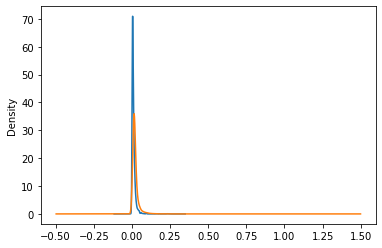

In [20]:
import pandas as pd

import numpy as np

 
data = pd.read_csv("HSMDData.csv")

index_ham = data[data['labels']==0].index.values.astype(int)

index_spam = data[data['labels']==1].index.values.astype(int)

 

num_s = int(index_spam.shape[0]*0.15)

 

for i in range(num_s):

    T = data.loc[index_ham[i], 'text']

    I = data.loc[index_ham[i], 'pics']

 

    #print(I)

 

    data.loc[index_ham[i], 'text'] = data.loc[index_spam[i], 'text']

    data.loc[index_ham[i], 'pics'] = data.loc[index_spam[i], 'pics']

 

    #print(data.loc[index_spam[i], 'pics'])

 

    data.loc[index_spam[i], 'text'] = T

    data.loc[index_spam[i], 'pics'] = I

 

''''

num_h = int(index_ham.shape[0]*0.15)

 

data.loc[index_ham[0:num_h],'labels'] = 1

data.loc[index_spam[0:num_s], 'labels'] = 0

'''

 

data = data.iloc[np.random.permutation(len(data))]

#data.to_csv('C:/codes_data/MMTD/V2/HSMDData15.csv')

 

H = data.loc[index_ham, 'repeated_chars']

H.plot.kde()

S= data.loc[index_spam, 'repeated_chars']

S.plot.kde()